In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.plotting import color_dict, marker_dict, core_legend, scatter_random_z

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_lig_test = pd.read_csv(data_dir / "ligand_test_data.csv")

model_dir = Path("../../models/")

In [4]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.SSE
    is_nn: bool = False
    prediction = np.zeros(len(df_lig_test))
    uncertainty = np.zeros(len(df_lig_test))

In [5]:
krr_experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
]
nn_experiments = [
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]
experiments = krr_experiments + nn_experiments

In [6]:
for experiment in krr_experiments + nn_experiments:
    x, _ = data_prep(
        df_lig_test, experiment.features, experiment.target, experiment.is_nn
    )
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        experiment.prediction, experiment.uncertainty = model.predict(x, verbose=0)
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        y_mean, y_std = model.predict(x, return_std=True)
        experiment.prediction = y_mean.reshape(-1, 1)
        experiment.uncertainty = y_std.reshape(-1, 1)

2024-04-01 19:54:03.449974: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
test_ligands = [
    "4H-pyran",
    "[OH]-[CH]=[CH]-[OH]",
    "bifuran",
    "pyridine-N-oxide",
    "acrylamide",
    "dmf",
    "thiophene",
    "thiane",
    "4H-thiopyran",
    "oxazoline",
    "thioazole",
    "[NH]=[CH]-[OH]",
    "[PH]=[CH]-[OH]",
    "[NH2]-[NH]-[NH]-[NH2]",
    "1H-tetrazole",
    "1H-triazole",
    "thioformaldehyde",
    "[NH2]-[O]-[O]-[NH2]",
    "bipyrimidine",
    "[PH2]-[CH2]-[OH]",
    "[PH2]-[NH]-[NH]-[PH2]",
]

In [8]:
ligand_names = {name: name for name in test_ligands}
ligand_names["[OH]-[CH]=[CH]-[OH]"] = "ethenediol"
ligand_names["[NH]=[CH]-[OH]"] = "??formamide??"
ligand_names["[PH]=[CH]-[OH]"] = "??phosphoral??"
ligand_names["[NH2]-[NH]-[NH]-[NH2]"] = "tetrazane"
ligand_names["[NH2]-[O]-[O]-[NH2]"] = "aminoperoxide"
ligand_names["[PH2]-[CH2]-[OH]"] = "hydroxymethylphosphine"
ligand_names["[PH2]-[NH]-[NH]-[PH2]"] = "bis(phosphanyl)hydrazine"
ligand_names["dmf"] = "dimethylformamide"

In [9]:
model_names = {
    "krr_standard_racs": "KRR standard-RACs",
    "krr_two_body": "KRR two-body",
    "krr_three_body": "KRR three-body",
    "nn_standard_racs": "NN standard-RACs",
    "nn_two_body": "NN two-body",
    "nn_three_body": "NN three-body",
}

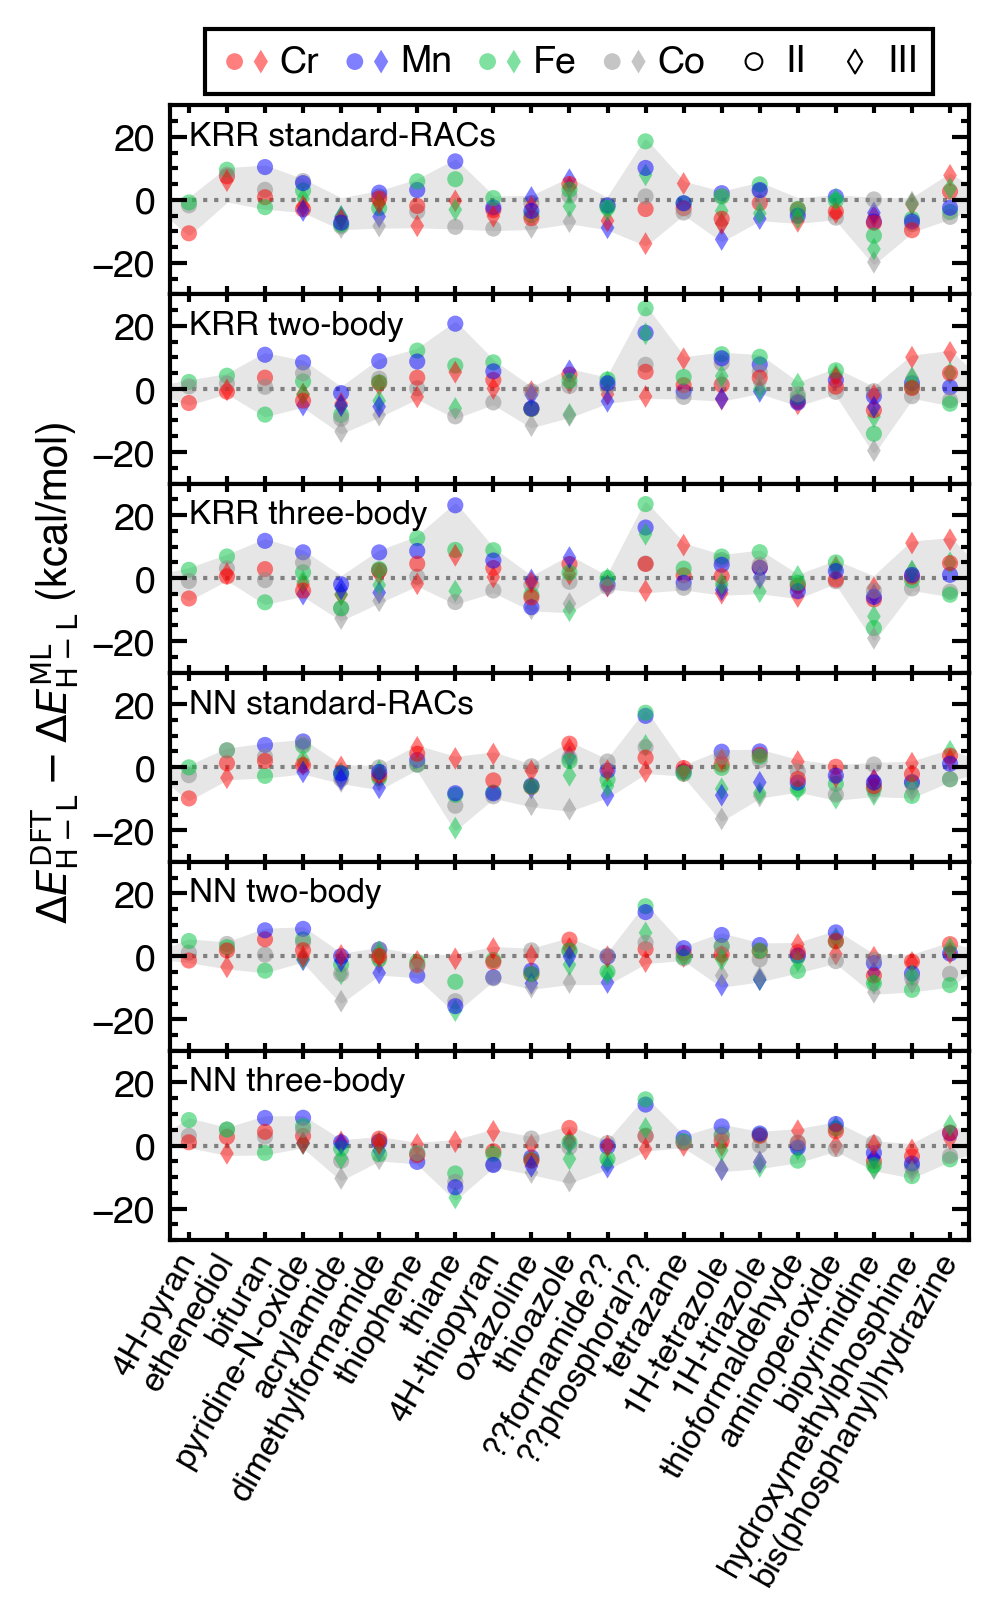

In [10]:
_, y = data_prep(df_lig_test, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False)
cores = df_lig_test[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
ligands = df_lig_test["name"].str.split("_", expand=True)[2]

fill_between = True
colors = np.array([color_dict[core[:2]] for core in cores])
markers = np.array([marker_dict[core[-1]] for core in cores])
# Sort the results by the ligands
plot_x = np.argmax(ligands.values[:, np.newaxis] == test_ligands, axis=1)

figsize = (3.33, 1.6 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.16,
    "right": 0.96,
    "top": 0.94,
    "bottom": 0.23,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=1,
    nrows=6,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 15, "alpha": 0.5, "edgecolors": "none"}
lower_lim = -30.0
upper_lim = 30.0

for experiment, ax in zip(experiments, axes):
    scatter_random_z(
        ax,
        plot_x,
        experiment.prediction - y,
        colors,
        markers,
        **scatter_kwargs,
    )
    ax.set_xlim(-0.5, 20.5)
    ax.set_ylim(lower_lim, upper_lim)
    ax.set_yticks(5 * np.arange(lower_lim // 5, upper_lim // 5), minor=True)
    ax.set_yticks([-20, 0, 20])
    ax.axhline(0, color="0.5", linestyle=":", zorder=0.5)
    ax.set_xticks(np.arange(21))
    ax.tick_params(length=2, axis="x")
    ax.set_xticklabels(
        [ligand_names[name] for name in test_ligands],
        rotation=60,
        ha="right",
        va="center",
        rotation_mode="anchor",
        fontsize=8,
    )
    ax.text(0, 25, model_names[experiment.name], ha="left", va="top", fontsize=8)

    if fill_between:
        # This vector is 2 entries longer than the number of ligands to enable
        # "tappering off" at the ends
        x_vec = np.arange(-1, len(test_ligands) + 1)
        y1 = np.zeros(len(x_vec))
        y2 = np.zeros(len(x_vec))
        for i in range(len(test_ligands)):
            deviations = (experiment.prediction - y).flatten()[plot_x == i]
            y1[i + 1] = max(0, deviations.max())
            y2[i + 1] = min(0, deviations.min())
        ax.fill_between(x_vec, y1, y2, color="0.9", zorder=0.0)

fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}} - \Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    rotation=90,
    va="center",
)

# Legend
core_legend(
    axes[0],
    legend_kwargs=dict(
        loc="upper left",
        bbox_to_anchor=[0.02, 1.5],
        markerscale=0.9,
        handletextpad=0.1,
        columnspacing=0.55,
    ),
)

fig.savefig("plots/error_plot_sse_lig_test.pdf")

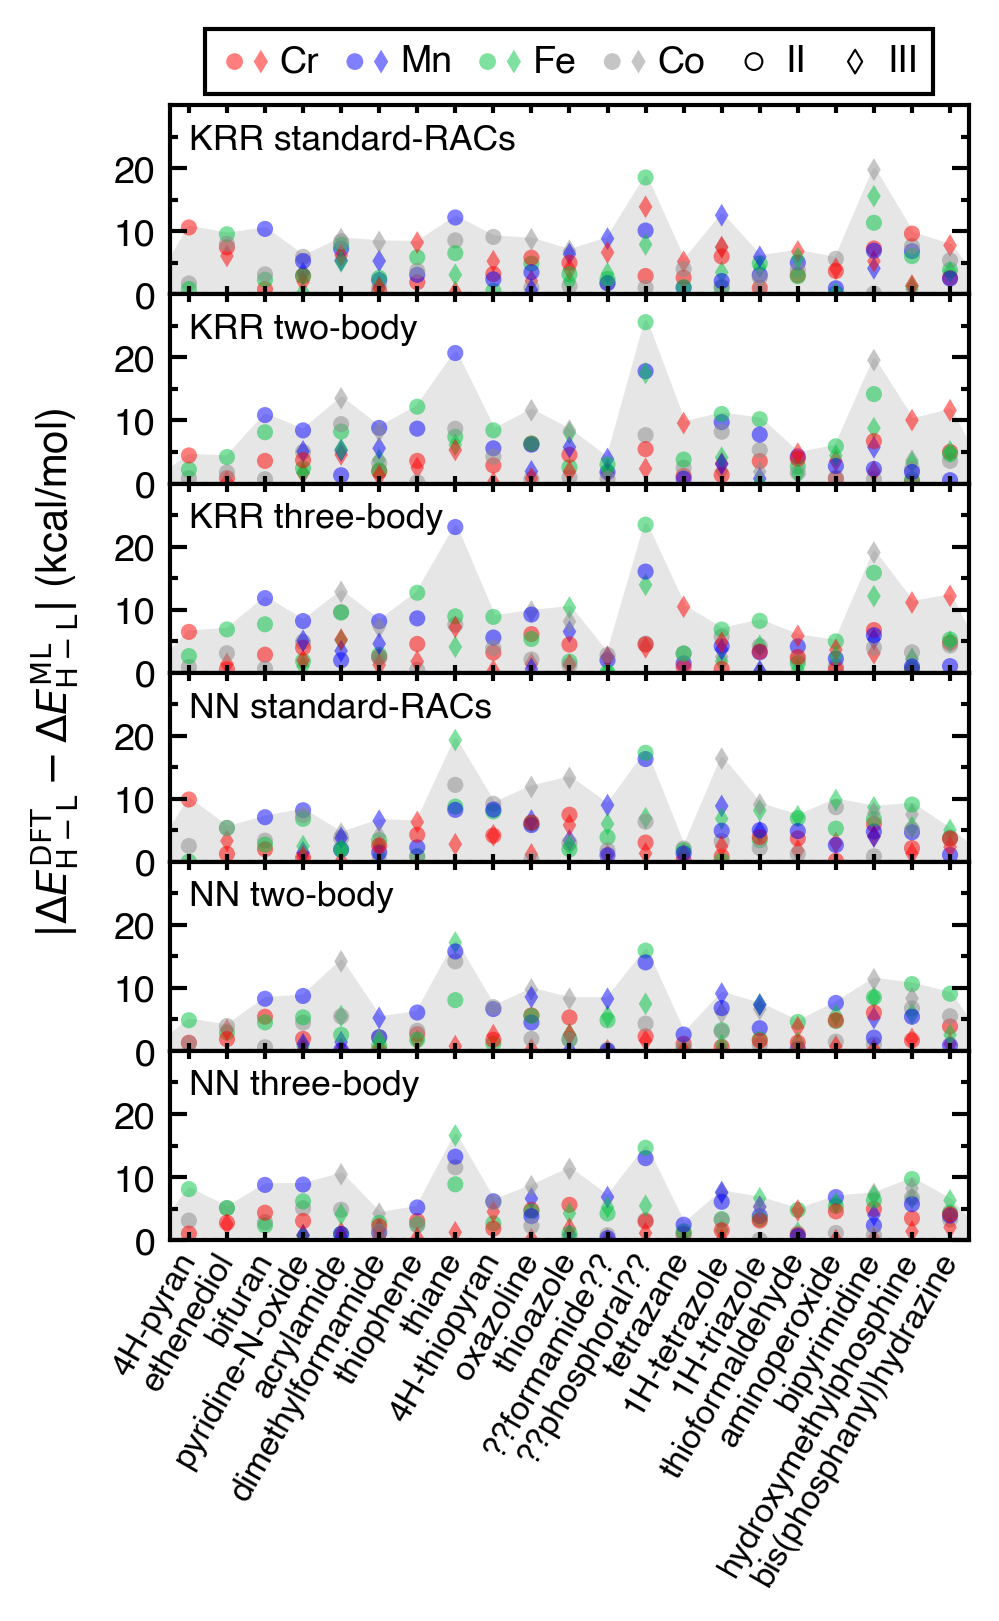

In [12]:
_, y = data_prep(df_lig_test, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False)
cores = df_lig_test[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
ligands = df_lig_test["name"].str.split("_", expand=True)[2]

fill_between = True
colors = np.array([color_dict[core[:2]] for core in cores])
markers = np.array([marker_dict[core[-1]] for core in cores])
# Sort the results by the ligands
plot_x = np.argmax(ligands.values[:, np.newaxis] == test_ligands, axis=1)

figsize = (3.33, 1.6 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.16,
    "right": 0.96,
    "top": 0.94,
    "bottom": 0.23,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=1,
    nrows=6,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 15, "alpha": 0.5, "edgecolors": "none"}
lower_lim = 0.0
upper_lim = 30.0

for experiment, ax in zip(experiments, axes):
    scatter_random_z(
        ax,
        plot_x,
        abs(experiment.prediction - y),
        colors,
        markers,
        **scatter_kwargs,
    )
    ax.set_xlim(-0.5, 20.5)
    ax.set_ylim(lower_lim, upper_lim)
    ax.set_yticks(5 * np.arange(lower_lim // 5, upper_lim // 5), minor=True)
    ax.set_yticks([0, 10, 20])
    ax.axhline(0, color="0.5", linestyle=":", zorder=0.5)
    ax.set_xticks(np.arange(21))
    ax.tick_params(length=2, axis="x")
    ax.set_xticklabels(
        [ligand_names[name] for name in test_ligands],
        rotation=60,
        ha="right",
        va="center",
        rotation_mode="anchor",
        fontsize=8,
    )
    ax.text(0, 27, model_names[experiment.name], ha="left", va="top", fontsize=8.5)

    if fill_between:
        # This vector is 2 entries longer than the number of ligands to enable
        # "tappering off" at the ends
        x_vec = np.arange(-1, len(test_ligands) + 1)
        y1 = np.zeros(len(x_vec))
        y2 = np.zeros(len(x_vec))
        for i in range(len(test_ligands)):
            deviations = abs(experiment.prediction - y).flatten()[plot_x == i]
            y1[i + 1] = max(0, deviations.max())
        ax.fill_between(x_vec, y1, y2, color="0.9", zorder=0.0)

fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$|\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}} - \Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}|$ (kcal/mol)",
    rotation=90,
    va="center",
)

# Legend
core_legend(
    axes[0],
    legend_kwargs=dict(
        loc="upper left",
        bbox_to_anchor=[0.02, 1.5],
        markerscale=0.9,
        handletextpad=0.1,
        columnspacing=0.55,
    ),
)

fig.savefig("plots/error_plot_sse_lig_test_alt.pdf")